
# Low-Pass $\pi$-LC Butterworth Filter

For a low pass $\pi$-LC filter to be a Butterworth filter, the insertion loss of the filter must have the following form:

\begin{equation}
Insertion\; loss\,(dB) = \frac{1}{K^{2}(1+\omega^{6})}
\end{equation}

If the filter is connected to a source with real impedance $R_{s}$ and a load with real impedance $R_{l}$ such that $R_{s} = \alpha R_{l}$, we have the following constraints on the choices for the **normalized** values of $L, C_{1}, C_{2}$ based on the form of the insertion loss.


\begin{gather}
L^{3}C^{4}_{2} + (\alpha + 1)^{2}L = 2\alpha(\alpha + 1)\left(\frac{\alpha + 1}{\alpha}C_{2} + LC_{2}^{3}\right) \tag{1}\\
L^{4}C_{2}^{2} + \alpha^{2}\left(\frac{\alpha + 1}{\alpha} + LC_{2}^{2}\right)^{2} = 2L^{3}C_{2}^{3} + 2\alpha(\alpha + 1)L^{2}C_{2} \tag{2}\\
C_{1} = \frac{\alpha + 1}{\alpha}\frac{1}{LC_{2}} \tag{3}
\end{gather}


There are two solutions to this system of equations but one of the solutions is surprisingly simple:

\begin{gather}
C_{1} = \frac{1}{\alpha} \\
C_{2} = 1 \\
L = \alpha + 1
\end{gather}

Unfortunately, this solution leads to unrealistic values for the inductor and capacitances and are only viable at high frequencies. The other solution is more realistic but does not have a simple closed form like the one above. Below we plot constraints (1) and (2) in the $L-C_{2}$ plane and numerically solve for the intersection. 

However, keep in mind the result is for **normalized** values of $L$ and $C_{2}$, normalized to the load $R_{l}$ and the cutoff frequency $\omega_{c}$. We get the unnormalized values as follows:

\begin{gather}
C_{2}^{'} = \frac{C_{2}}{2\pi f_{c}R_{l}}\\
L^{'} = \frac{LR_{l}}{2\pi f_{c}}
\end{gather}

$C_{2}^{'}$ and $L^{'}$ are the actual values for the capacitance and inductance that you would use for the filter. The same procedure applies for $C_{1}$ to get $C_{1}^{'}$. The unnormalized values are calculated below as well.

<IPython.core.display.Javascript object>


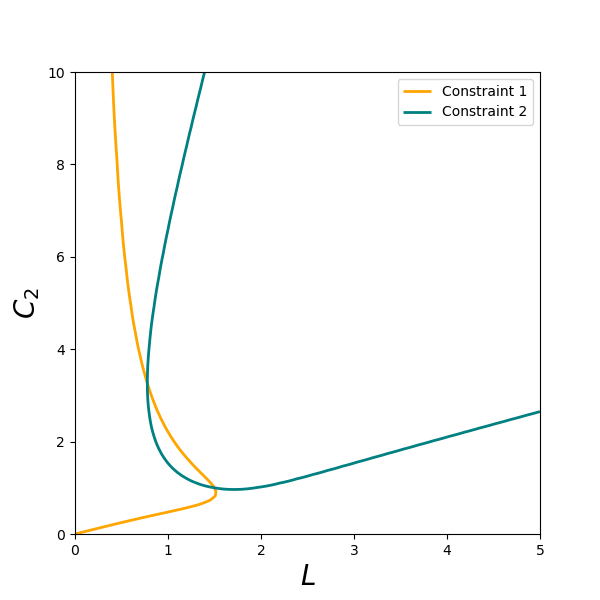

In [8]:
%matplotlib notebook

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive

# Constraint functions

def constraint1(a, x, c):
    return x**3 * c**4 + x*(a + 1)**2 - 2*a*(a + 1)*(c*(a + 1)/a + x*c**3)

def constraint2(a, x, c):
    return x**4 * c**2 + a**2 * ((a + 1)/a + x*c**2)**2 - 2*x**3 * c**3 - 2*a*(a + 1)*c*x**2

def constraints(x, a):
    return [x[0]**3 * x[1]**4 + x[0]*(a + 1)**2 - 2*a*(a + 1)*(x[1]*(a + 1)/a + x[0]*x[1]**3),
           x[0]**4 * x[1]**2 + a**2 * ((a + 1)/a + x[0]*x[1]**2)**2 - 2*x[0]**3 * x[1]**3 - 2*a*(a + 1)*x[1]*x[0]**2]

def jacob(x, a):
    return [[
        3*x[0]**2 * x[1]**4 + (a+1)**2 - 2*a*(a+1)*x[1]**3,
        4*x[0]**3 * x[1]**3 - 2*a*(a+1)*((a+1)/a + 3*x[0]*x[1]**2)],
        [4*x[0]**3 * x[1]**2 + 2*a**2 * x[1]**2 *((a+1)/a + x[0]*x[1]**2) - 6*x[0]**2 * x[1]**3 - 4*a*(a+1)*x[0]*x[1],
        2*x[0]**4 * x[1] + 4*a**2 * x[1]*x[0]*((a+1)/a + x[0]*x[1]**2) - 6*x[0]**3 * x[1]**2 - 2*a*(a+1)*x[0]**2]]

# Initial plotting setup
alpha = 0.5
l, c2 = np.meshgrid(np.linspace(0, 5, 101), np.linspace(0, 10, 110))

z1 = constraint1(alpha, l, c2)
z2 = constraint2(alpha, l, c2)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylabel(r'$C_{2}$', fontsize=20)
ax.set_xlabel(r'$L$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=10)

contour1 = ax.contour(l, c2, z1, (0), linewidths = (2), colors = ('orange'), linestyles = 'solid')
contour2 = ax.contour(l, c2, z2, (0), linewidths = (2), colors = ('teal'), linestyles = 'solid')

legend = ax.legend((contour1.collections[0], contour2.collections[0]), ('Constraint 1', 'Constraint 2'), loc = 'upper right')

result = root(constraints, x0 = [2.5, 20 if alpha < 1 else 0.5], args = (alpha), method = 'hybr', jac = jacob)

# Widget setup

out = Output()
width = {'width': '200px'}

alphaSlide = FloatSlider(value=0.5, min=0.01, max=5, step=0.01, description = r'$\alpha$', 
                         continuous_update = False, layout = {'width':'500px'})

cutoff = FloatText(value = 10000, description = r'$f_{c}$', layout = width)

load = IntText(value = 1000, description = r'$R_{l}$', layout = width)

with out:
    print('L = {:.2e}, C2 = {:.2f}'.format(result.x[0], result.x[1]))
    scaledL = result.x[0]*load.value / (math.pi * cutoff.value)
    scaledC2 = result.x[1] / (load.value * math.pi * cutoff.value)
    scaledC1 = (alpha + 1) / (alpha * result.x[0] * result.x[1] * load.value * math.pi * cutoff.value)
    print('L\' = {:.2e}, C2\' = {:.2e}, C1\' = {:.2e}'.format(scaledL, scaledC2, scaledC1))

def update(a, cutoff, load):
    ax.clear()
    z1 = constraint1(a, l, c2)
    z2 = constraint2(a, l, c2)
    
    contour1 = ax.contour(l, c2, z1, (0), linewidths = (2), colors = ('orange'), linestyles = 'solid')
    contour2 = ax.contour(l, c2, z2, (0), linewidths = (2), colors = ('teal'), linestyles = 'solid')
    
    legend = ax.legend((contour1.collections[0], contour2.collections[0]), ('Constraint 1', 'Constraint 2'), loc = 'upper right')
    ax.set_ylabel(r'$C_{2}$', fontsize=20)
    ax.set_xlabel(r'$L$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    result = root(constraints, x0 = [2.5, 20 if a < 1 else 0.5], args = (a), method = 'hybr', jac = jacob)
    
    with out:
        out.clear_output()
        print('L = {:.2e}, C2 = {:.2f}'.format(result.x[0], result.x[1]))
        scaledL = result.x[0]*load / (math.pi * cutoff)
        scaledC2 = result.x[1] / (load * math.pi * cutoff)
        scaledC1 = (a + 1) / (a * result.x[0] * result.x[1] * load * math.pi * cutoff)
        print('L\' = {:.2e}, C2\' = {:.2e}, C1\' = {:.2e}'.format(scaledL, scaledC2, scaledC1))


it = interactive(update, a = alphaSlide, cutoff = cutoff, load = load)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

vbox = VBox(children = (alphaSlide, cutoff, load), layout = box_layout)
hbox = HBox(children = (vbox, out))

display(hbox)


# AC DC MIXER CIRCUIT
The following circuit uses an audio transformer to mix a DC signal on the secondary with an AC signal on the primary. $Z$ is the impedance of the load. 

![AC DC Mixer](img/AC_DC_mixer.png)

The transformer is characterized by a mutual inductance of $M$ with perfect coupling and self-inductances of $L_{p}$ and $L_{s}$ on the primary and secondary windings. The primary winding is connected to the AC source. The corresponding voltage and current law equations are as follows:

\begin{align}
V_{d} &= I_{1}R + V_{c} \\
-I_{2}Z &= V_{c} + M\frac{dI_{3}}{dt} + L_{s}\frac{dI_{2}}{dt} \\
V_{a} &= M\frac{dI_{2}}{dt} + L_{p}\frac{dI_{3}}{dt} + I_{3}R_{3} \\
C\frac{dV_{c}}{dt} &= I_{1} + I_{2}
\end{align}

Using the fact that $M = nL_{s}$ for perfect coupling, with $n$ being the turns ratio, and combining the equations results in a second-order differential equation for $V_{c}$:

\begin{equation}
\frac{dV_{a}}{dt} - KV_{d} = A\frac{d^{2}V_{c}}{dt^{2}} + B\frac{dV_{c}}{dt} + DV_{c}
\end{equation}

The coefficients are defined as:

\begin{align}
A &= \frac{C}{M}\left(-ZL_{p} + R_{3}L_{s} \right)\\
B &= -\frac{1}{M}\left(\frac{ZL_{p}}{R} + L_{p} + R_{3}ZC +\frac{R_{3}L_{s}}{R} \right)\\
D &= -\frac{R_{3}}{M}\left(\frac{Z}{R} + 1\right)\\
K &= \frac{R_{3}Z}{RM}
\end{align}

In this scenario, we only care about the long term solution caused by the driving sources $V_{a}, V_{d}$. Because of that, we can ignore the homogenous solution to this differential equation since that solution corresponds to a scenario in which $V_{a}, V_{d} = 0$ and the behavior of the circuit is determined by initial conditions, specifically what is the initial charge in the capacitor and current flowing through the wires. We expect that the homogenous solution will die out in the long term due to the inherent damping caused by the resistors. 

Since the circuit has a DC source being modulated by an AC source $V_{a}e^{jwt}$, we expect the solution to have the form: $V_{c} = Ve^{jwt} + V_{0}$. Substituting this trial solution in gives the following values:
\begin{align}
V_{0} &= \frac{Z}{R+Z}V_{d} \\
V &= \frac{j\omega V_{a}}{-\omega^{2}A + j\omega B + D}
\end{align}

As expected, the DC offset voltage $V_{0}$ we get is simply the voltage we get from a voltage divider. In addition, the larger the capacitance, the smaller the AC component of $V$ becomes because the capacitance starts to act more like a short. From here we can calculate the voltage across the load $V_{z}$ as:

\begin{equation}
V_{z} = \frac{ZV_{d}}{R+Z} - \frac{Z(1+j\omega RC)}{R}Ve^{jwt}
\end{equation}

In addition, the amplitude of the oscillating portion of current $I_{1}$ is given as $V/R$ so the larger the source resistance, the smaller the oscillating current flowing through that branch. 

Below we plot the AC amplitude of $V_{z}$ as a function of frequency.  

<IPython.core.display.Javascript object>


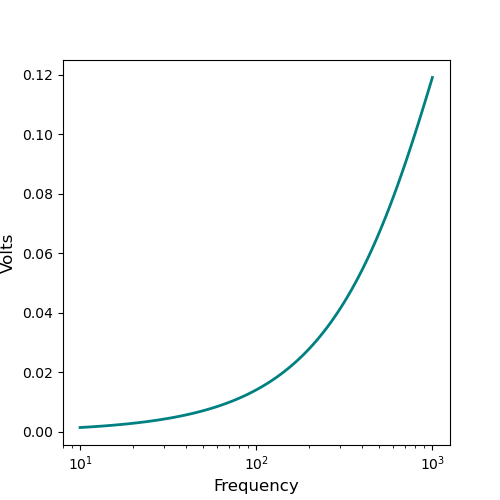

In [6]:
%matplotlib notebook

import math
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive


# define circuit parameters
# params = (r, r3, z, c, n, ls)
params = (10000, 1000, 10000, 10**-5, 4.472, .005)

def coeffB(r, r3, z, c, n, ls):
    return -(z*n**2 * ls / r + n**2 * ls + r3*z*c + r3 * ls / r) / (n * ls)

def coeffA(r, r3, z, c, n, ls):
    return c / (n * ls) * (r3*ls - z*n**2 * ls)

def coeffD(r, r3, z, c, n, ls):
    return -r3 / (n * ls) * (1 + z/r)

def amplitude(w, *params):
    z = params[2]
    r = params[0]
    c = params[3]
    top = z/r * w * math.sqrt(1 + w**2 * r**2 * c**2)
    return top / math.sqrt((coeffD(*params) - w**2 * coeffA(*params))**2 + w**2 * (coeffB(*params))**2)

def ampArray(freq, params):
    return np.array([amplitude(w, *params) for w in freq])

# build graph

freq = np.logspace(1, 3, 101, base = 10)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylabel('Volts', fontsize=12)
ax.set_xlabel('Frequency', fontsize=12)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=10)

curve, = ax.plot(freq, ampArray(2*math.pi*freq, params), linewidth = 2, color = 'teal')

# widget setup

width = {'width': '200px'}
resist = IntText(value = 10000, description = r'$R$', layout = width)
resist3 = IntText(value = 1000, description = r'$R_{3}$', layout = width)
load = IntText(value = 10000, description = r'$Z$', layout = width)
cap = FloatText(value = 10**-5, description = r'$C$', layout = width)
turns = FloatText(value = 4.47, description = r'$n$', layout = width)
l2 = FloatText(value = 0.005, description = r'$L_{s}$', layout = width)

def update(resist, resist3, load, cap, turns, l2):
    curve.set_ydata(ampArray(2*math.pi*freq, (resist, resist3, load, cap, turns, l2)))
    #ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw_idle()

it = interactive(update, resist = resist, resist3 = resist3, load = load, cap = cap, turns = turns, l2 = l2)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')


vbox1 = VBox(children = (resist, resist3, load), layout = box_layout)
vbox2 = VBox(children = (cap, turns, l2), layout = box_layout)
hbox = HBox(children = (vbox1, vbox2), layout = Layout(display = 'flex', justify_content = 'flex-start'))

display(hbox)


# Double RC Low-Pass Filter

Consider the double RC low-pass filter below. 

![Double RC Filter](img/doublercfilter.png)

Here we have that $R_{1} = \alpha Z$ and $R_{2} = \beta Z$ with $\alpha, \beta$ being real, positive constants. The magnitude squared of the transfer function of this filter at the load $Z$ is given in general by something of the form:

\begin{equation}
|H(\omega)|^{2} = \frac{1}{K^{2}(1+g\omega^{2}+\gamma^{2}\omega^{4})}
\end{equation}

Here we are considering a **normalized** transfer function. So all the circuit values are normalized to the load $Z$ and some cutoff frequency $\omega_{c}$.  In addition, we only consider *positive* values for the coefficients $K, g, \gamma$. These coefficients are related to the normalized circuit values as follows:

\begin{gather}
K = 1 + \alpha + \beta \\
\gamma = \frac{\alpha \beta C_{1}C_{2}}{K} \\
g = \frac{1}{K^{2}}\left(\beta C_{2} + \alpha(C_{1}+C_{2}) + \alpha \beta C_{1} \right)^{2} -\frac{2\alpha \beta C_{1}C_{2}}{K}
\end{gather}

Furthermore, the fact that the capacitances and resistances must have real positive values, we find the following constraints for the coefficients in the transfer function. 

\begin{align}
g+2\gamma &> 4(1-\frac{1}{K}) \\
K-1 \geq \beta &\geq \frac{4(K-1)}{g+2\gamma+(K-1)(g+2\gamma-4)}
\end{align}

Therefore $g, \gamma$ cannot be arbitary values if they are to be realized by this specific circuit with these specific types of circuit components. We can also go the other way. Given, $K, g, \gamma$, we can calculate the corresponding **normalized** circuit component values:

\begin{gather}
\alpha = K - 1 - \beta \\
C_{2} = \frac{\gamma K}{\alpha \beta C_{1}} \\
C_{1} = \frac{\alpha \beta K\sqrt{g+2\gamma} + \sqrt{(g+2\gamma)(\alpha \beta K)^{2}
-4\alpha^{2}\beta K(1+\beta)(\alpha + \beta)}}{2\alpha^{2}\beta(1+\beta)}
\end{gather}

Notice that $\beta$ remains as an independent variable. This is because the original circuit had 4 independent component choices, $R_{1}, R_{2}, C_{1}, C_{2}$. The number of independent constraints must be preserved even when we change variables to $K, g, \gamma$. Unfortunately, since $K, g, \gamma$ comprise of only 3 choices, one of the previous independent variables, in this case $\beta$, must continue to stay as an independent variable. 

Below we plot out the magnitude squared of the transfer function, $|H(\omega)|^{2}$ as a function of normalized frequency for different choices of the coefficients $K, g, \gamma$. The corresponding unnormalized circuit component values are also calculated. 

<IPython.core.display.Javascript object>


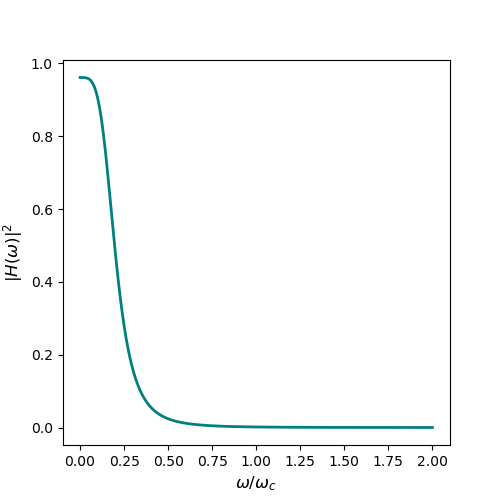

In [9]:
%matplotlib notebook

import math
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, BoundedFloatText

# define transfer function and component equations

coeff = (1.02, 0.1, 25)

def transfer(w, k, g, y):
    return 1 / (k**2 * (1 + g*w**2 + y**2 * w**4))

def transferArray(freq, k, g, y):
    return np.array([transfer(w, k, g, y) for w in freq])

def alpha(b, k):
    return k - 1 - b

def capOne(b, k, g, y):
    return (alpha(b, k)*b*k*math.sqrt(g+2*y) + math.sqrt((g+2*y)*(b*k*alpha(b,k))**2 - 4*b*k*alpha(b, k)**2 *(1+b)*(alpha(b, k) + b))) / (2*alpha(b, k)**2 * b * (1+b))

def capTwo(b, k, g, y):
    return y*k/ (alpha(b, k)*b*capOne(b, k, g, y))

def lowerBBound(k, g, y):
    return 4*(k-1)/(g+2*y+(k-1)*(g+2*y-4))

# setup plots

freq = np.linspace(0, 2, 201)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylabel(r'$|H(\omega)|^{2}$', fontsize=12)
ax.set_xlabel(r'$\omega / \omega_{c}$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

curve, = ax.plot(freq, transferArray(freq, *coeff), linewidth = 2, color = 'teal')

# widget setup

out = Output()

gSlide = FloatSlider(value=0.1, min=0.1, max=20, step=0.01, description = r'$g$', 
                         continuous_update = False, layout = {'width':'500px'})

ySlide = FloatSlider(value=25, min=0.1, max=100, step=0.1, description = r'$\gamma$', 
                         continuous_update = False, layout = {'width':'500px'})

kText = BoundedFloatText(value = 1.02, min = 1, max = 10, step = .00001, description = r'$K$', layout = {'width':'200px'})

bText = BoundedFloatText(value = .01075, min = .001, max = 10, step = .00001, description = r'$\beta$', layout = {'width':'200px'})

loadText = FloatText(value = 500000, description = r'$Z$', layout = {'width':'200px'})

cutoff = FloatText(value = 5000, description = r'$f_c$', layout = {'width':'200px'})

def update(b, k, g, y, l, c):
    out.clear_output()

    if g+2*y <= 4 - 4/k:
        with out:
            print('g+2y > 4(1-1\K) condition not satisfied.')
        return
    
    newLowerBound = lowerBBound(k, g, y)
    newUpperBound = k - 1
    
    if b < newLowerBound or b > newUpperBound:
        with out:
            print('B needs to lie in the interval ({:.2e},{:.2e})'.format(newLowerBound, newUpperBound))
        return
    
    c2 = capTwo(b, k, g, y) / (2*math.pi*c*l)
    c1 = capOne(b, k, g, y) / (2*math.pi*c*l)
    
    with out:
        print('a = {:.2e}, C1 = {:.2e}, C2 = {:.2e}'.format(alpha(b,k), c1, c2))
    
    
    curve.set_ydata(transferArray(freq, k, g, y))
    fig.canvas.draw_idle()


it = interactive(update, b = bText, k = kText, g = gSlide, y = ySlide, l = loadText, c = cutoff)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

vbox = VBox(children = (kText, bText), layout = box_layout)
vbox2 = VBox(children = (loadText, cutoff), layout = box_layout)
vbox3 = VBox(children = (gSlide, ySlide), layout = box_layout)
hbox = HBox(children = (vbox, vbox2))
hbox2 = HBox(children = (VBox(children = (hbox, vbox3)), out))

display(hbox2)
    